# Model Preparation using SageMaker APIs

## Introduction

This is a sample jupyter notebook that explains how to use Ambarella's Model Preperation Service using AWS SageMaker Python APIs. 
Users can subscribe to the algorithm from the product listing page: 
[Ambarella MPS](https://aws.amazon.com/marketplace/pp/prodview-b6kcmli2ly6ji)

The algorithm published does Object Detection on user's dataset. There are 2 components to SageMaker: 

**1. Preparing the model:**<br> 
Users are provided with options for hyper-parameters allowing them to train the model for their dataset. The output of training is Ambarella's proprietary AmbaPB fast checkpoint. 

**2. Running Inference:**<br> 
Users can run batch transforms or real time predictions on the output of training. The inference does the detection and outputs in application/json format which contains the boxes, scores and labels output. 

## Preparing the data

The training and validation dataset must follow certain rules as stated below: 

> dataset_dir/     
>> labels.json    
>> data/         
>>> filename0.jpg    
>>> filename1.jpg    
>>> ...

The label file must follow the COCO definition (Reference: https://cocodataset.org/#format-data) as mentioned in the next cell

In [1]:
JSON = {
    "info": {'xxx'},
    "licenses": [
        {
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License",
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
        }
    ],
    "categories": [
        {
            "id": 2,
            "name": "cat",
            "supercategory": "animal",
            "keypoints": ["nose", "head", ...],
            "skeleton": [[12, 14], [14, 16], ...]
        }
    ],
    "images": [
        {
            "id": 1,
            "license": 1,
            "file_name": "<filename0>.jpg",
            "height": 480,
            "width": 640,
            "date_captured": "null"
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 1,
            "category_id": 2,
            "bbox": [260, 177, 231, 199],
            "segmentation": [...],
            "keypoints": [224, 226, 2, ...],
            "num_keypoints": 10,
            "score": 0.95,
            "area": 45969,
            "iscrowd": 0
        }
    ]
}

## Run Training

Training requires the following: 
1. SageMaker python package installed.<br>
2. Hyper-parameters as dictionary<br>
3. Instance type<br>
4. Subscription to Ambarella's algorithm<br>
5. Access to S3 location for input and output data exchanges<br>

### Install sagemaker python API

In [2]:
!python3 -m pip install sagemaker

setting up for ubuntu environment


#### Import packages

In [3]:
from sagemaker.estimator import Estimator
import boto3
import json
import enum
from util import *
import tarfile
from IPython.display import Image as display_image
import cv2

### Describe Hyperparameters

In [4]:
hyperparameters = {
    
    "batch_size":"8",
    "weight_decay":"0.0005",
    "num_classes":"21",
    "compression_level":"1",
    "eps":"1e-8",
    "monitor":"val_acc",
    "early_stopping":"True",
    "num_workers":"4",
    "momentum":"0.9",
    "lr_scheduler_factor":"0.1",
    "min_delta":"0.002",
    "lr_scheduler":"MultiStepLR",
    "optimizer":"sgd",
    "patience":"5",
    "backbone":"vgg16",
    "compression":"True",
    "epochs":"1",
    "learning_rate":"0.00004",
    "step_size":"20",
    "nms_thresh":"0.45",
    "iou_thresh":"0.5",
    "milestones":"50,70"
}

### Providing path to S3 location for train & val data

In [5]:
# Set the path to training and validation dataset 
input_data = {
            'train':'s3://<user_path>/train/',  
            'val':'s3://<user_path>/val/'
            }


### Call the estimator API and create an estimator object

Create a role on AWS IAM to allow access to SageMaker<br>
Provide a GPU instance such as ml.p2.xlarge to run training.<br>
Provide the image_uri to the subscribed algorithm


In [6]:
# Call the estimator API with role, image_uri, hyper-parameters, s3 path.

estimator = Estimator(
    role='arn:aws:iam::user_account:role/SageMakerTraining',
    instance_count=1,
    instance_type='ml.p2.xlarge',
    image_uri='subscribed_uri',
    hyperparameters=hyperparameters,
    output_path='s3://<output_path>',
    base_job_name='test-notebook'
)


INFO: 03/07/2022 14:35:12.005847 credentials.py:1233 [cvflowbackend] Found credentials in shared credentials file: ~/.aws/credentials


###  Call the fit() API to start training on AWS instances

In [7]:
estimator.fit(input_data)

INFO: 03/07/2022 14:35:12.609320 image_uris.py:272 [cvflowbackend] Defaulting to the only supported framework/algorithm version: latest.
INFO: 03/07/2022 14:35:12.718635 image_uris.py:298 [cvflowbackend] Ignoring unnecessary instance type: None.
INFO: 03/07/2022 14:35:12.723711 session.py:588 [cvflowbackend] Creating training-job with name: test-notebook-2022-03-07-22-35-12-535


2022-03-07 22:35:13 Starting - Starting the training job...
2022-03-07 22:35:16 Starting - Launching requested ML instancesProfilerReport-1646692512: InProgress
......
2022-03-07 22:36:46 Starting - Preparing the instances for training.........
2022-03-07 22:38:05 Downloading - Downloading input data............
2022-03-07 22:40:04 Training - Downloading the training image............................................--------------------------
AmbaTools Location Summary
--------------------------
AMBA_ROOT  = /home/cvdev/tools
--------------------------

2022-03-07 22:47:46 Training - Training image download completed. Training in progress./usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/early_stopping.py:118: LightningDeprecationWarning: The `EarlyStopping(monitor)` argument will be required starting in v1.6. For backward compatibility, setting this to `early_stop_on`.
  "The `EarlyStopping(monitor)` argument will be required starting in v1.6."
[WARNING] patience is se

#015                                                                      #015#015Training: -1it [00:00, ?it/s]#015Training:   0%|          | 0/1245 [00:00<00:00, 10618.49it/s]#015Epoch 0:   0%|          | 0/1245 [00:00<00:00, 2864.96it/s]  #015Epoch 0 (MetaEpoch 0):   0%|          | 0/1245 [00:00<00:00, 1802.45it/s]#015Epoch 0 (MetaEpoch 0):   0%|          | 1/1245 [00:01<17:53,  1.16it/s]  #015Epoch 0 (MetaEpoch 0):   0%|          | 1/1245 [00:01<17:53,  1.16it/s, loss=27.1, train_loss_step=27.10]#015Epoch 0 (MetaEpoch 0):   0%|          | 2/1245 [00:02<14:55,  1.39it/s, loss=27.1, train_loss_step=27.10]#015Epoch 0 (MetaEpoch 0):   0%|          | 2/1245 [00:02<14:56,  1.39it/s, loss=24.5, train_loss_step=22.00]#015Epoch 0 (MetaEpoch 0):   0%|          | 3/1245 [00:02<14:02,  1.47it/s, loss=24.5, train_loss_step=22.00]#015Epoch 0 (MetaEpoch 0):   0%|          | 3/1245 [00:02<14:03,  1.47it/s, loss=24.1, train_loss_step=23.30]#015Epoch 0 (MetaEpoch 0):   0%|          | 4/1245 [00:03<13

loss=14.3, train_loss_step=14.20]#015Epoch 0 (MetaEpoch 0):   6%|▌         | 75/1245 [00:36<09:25,  2.07it/s, loss=14.2, train_loss_step=13.40]#015Epoch 0 (MetaEpoch 0):   6%|▌         | 76/1245 [00:37<09:24,  2.07it/s, loss=14.2, train_loss_step=13.40]#015Epoch 0 (MetaEpoch 0):   6%|▌         | 76/1245 [00:37<09:24,  2.07it/s, loss=14.2, train_loss_step=14.00]#015Epoch 0 (MetaEpoch 0):   6%|▌         | 77/1245 [00:37<09:24,  2.07it/s, loss=14.2, train_loss_step=14.00]#015Epoch 0 (MetaEpoch 0):   6%|▌         | 77/1245 [00:37<09:24,  2.07it/s, loss=14.2, train_loss_step=14.10]#015Epoch 0 (MetaEpoch 0):   6%|▋         | 78/1245 [00:38<09:23,  2.07it/s, loss=14.2, train_loss_step=14.10]#015Epoch 0 (MetaEpoch 0):   6%|▋         | 78/1245 [00:38<09:23,  2.07it/s, loss=14.2, train_loss_step=13.80]#015Epoch 0 (MetaEpoch 0):   6%|▋         | 79/1245 [00:38<09:22,  2.07it/s, loss=14.2, train_loss_step=13.80]#015Epoch 0 (MetaEpoch 0):   6%|▋         | 79/1245 [00:38<09:22,  2.07it/s, loss=14.1,

tep=13.20]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 150/1245 [01:14<09:02,  2.02it/s, loss=13.4, train_loss_step=13.20]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 150/1245 [01:14<09:02,  2.02it/s, loss=13.4, train_loss_step=13.20]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 151/1245 [01:15<09:02,  2.02it/s, loss=13.4, train_loss_step=13.20]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 151/1245 [01:15<09:02,  2.02it/s, loss=13.4, train_loss_step=13.60]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 152/1245 [01:15<09:01,  2.02it/s, loss=13.4, train_loss_step=13.60]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 152/1245 [01:15<09:01,  2.02it/s, loss=13.4, train_loss_step=13.40]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 153/1245 [01:16<09:00,  2.02it/s, loss=13.4, train_loss_step=13.40]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 153/1245 [01:16<09:00,  2.02it/s, loss=13.4, train_loss_step=13.00]#015Epoch 0 (MetaEpoch 0):  12%|█▏        | 154/1245 [01:16<09:00,  2.02it/s, loss=13.4, train_loss_st

[01:51<08:29,  2.00it/s, loss=12.8, train_loss_step=13.10]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 223/1245 [01:51<08:29,  2.00it/s, loss=12.8, train_loss_step=12.80]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 224/1245 [01:52<08:29,  2.01it/s, loss=12.8, train_loss_step=12.80]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 224/1245 [01:52<08:29,  2.01it/s, loss=12.8, train_loss_step=12.80]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 225/1245 [01:52<08:28,  2.01it/s, loss=12.8, train_loss_step=12.80]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 225/1245 [01:52<08:28,  2.01it/s, loss=12.8, train_loss_step=12.90]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 226/1245 [01:53<08:27,  2.01it/s, loss=12.8, train_loss_step=12.90]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 226/1245 [01:53<08:27,  2.01it/s, loss=12.8, train_loss_step=12.60]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 227/1245 [01:53<08:27,  2.01it/s, loss=12.8, train_loss_step=12.60]#015Epoch 0 (MetaEpoch 0):  18%|█▊        | 227/1245 [

t/s, loss=12.3, train_loss_step=12.80]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 296/1245 [02:28<07:53,  2.00it/s, loss=12.3, train_loss_step=12.80]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 296/1245 [02:28<07:53,  2.00it/s, loss=12.3, train_loss_step=12.50]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 297/1245 [02:28<07:53,  2.00it/s, loss=12.3, train_loss_step=12.50]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 297/1245 [02:28<07:53,  2.00it/s, loss=12.3, train_loss_step=12.70]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 298/1245 [02:29<07:52,  2.00it/s, loss=12.3, train_loss_step=12.70]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 298/1245 [02:29<07:52,  2.00it/s, loss=12.3, train_loss_step=12.00]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 299/1245 [02:29<07:51,  2.01it/s, loss=12.3, train_loss_step=12.00]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 299/1245 [02:29<07:51,  2.00it/s, loss=12.3, train_loss_step=11.90]#015Epoch 0 (MetaEpoch 0):  24%|██▍       | 300/1245 [02:30<07:51,  2.01it

0%|██▉       | 368/1245 [03:02<07:13,  2.02it/s, loss=12, train_loss_step=11.90]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 368/1245 [03:02<07:13,  2.02it/s, loss=12.1, train_loss_step=12.30]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 369/1245 [03:05<07:18,  2.00it/s, loss=12.1, train_loss_step=12.30]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 369/1245 [03:05<07:18,  2.00it/s, loss=12.1, train_loss_step=11.60]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 370/1245 [03:05<07:17,  2.00it/s, loss=12.1, train_loss_step=11.60]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 370/1245 [03:05<07:17,  2.00it/s, loss=12, train_loss_step=11.50]  #015Epoch 0 (MetaEpoch 0):  30%|██▉       | 371/1245 [03:06<07:17,  2.00it/s, loss=12, train_loss_step=11.50]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 371/1245 [03:06<07:17,  2.00it/s, loss=12, train_loss_step=11.90]#015Epoch 0 (MetaEpoch 0):  30%|██▉       | 372/1245 [03:06<07:16,  2.00it/s, loss=12, train_loss_step=11.90]#015Epoch 0 (MetaEpoch 0):  30%|██▉   

,  2.02it/s, loss=11.6, train_loss_step=11.30]#015Epoch 0 (MetaEpoch 0):  35%|███▌      | 439/1245 [03:38<06:39,  2.02it/s, loss=11.6, train_loss_step=11.50]#015Epoch 0 (MetaEpoch 0):  35%|███▌      | 440/1245 [03:38<06:39,  2.02it/s, loss=11.6, train_loss_step=11.50]#015Epoch 0 (MetaEpoch 0):  35%|███▌      | 440/1245 [03:38<06:39,  2.02it/s, loss=11.6, train_loss_step=11.40]#015Epoch 0 (MetaEpoch 0):  35%|███▌      | 441/1245 [03:39<06:38,  2.02it/s, loss=11.6, train_loss_step=11.40]#015Epoch 0 (MetaEpoch 0):  35%|███▌      | 441/1245 [03:39<06:38,  2.02it/s, loss=11.5, train_loss_step=11.30]#015Epoch 0 (MetaEpoch 0):  36%|███▌      | 442/1245 [03:39<06:38,  2.02it/s, loss=11.5, train_loss_step=11.30]#015Epoch 0 (MetaEpoch 0):  36%|███▌      | 442/1245 [03:39<06:38,  2.02it/s, loss=11.5, train_loss_step=11.40]#015Epoch 0 (MetaEpoch 0):  36%|███▌      | 443/1245 [03:40<06:37,  2.02it/s, loss=11.5, train_loss_step=11.40]#015Epoch 0 (MetaEpoch 0):  36%|███▌      | 443/1245 [03:40<06:37,

n_loss_step=10.50]#015Epoch 0 (MetaEpoch 0):  41%|████      | 510/1245 [04:14<06:06,  2.01it/s, loss=11.3, train_loss_step=10.50]#015Epoch 0 (MetaEpoch 0):  41%|████      | 510/1245 [04:14<06:06,  2.01it/s, loss=11.3, train_loss_step=11.10]#015Epoch 0 (MetaEpoch 0):  41%|████      | 511/1245 [04:15<06:05,  2.01it/s, loss=11.3, train_loss_step=11.10]#015Epoch 0 (MetaEpoch 0):  41%|████      | 511/1245 [04:15<06:05,  2.01it/s, loss=11.3, train_loss_step=11.60]#015Epoch 0 (MetaEpoch 0):  41%|████      | 512/1245 [04:15<06:05,  2.01it/s, loss=11.3, train_loss_step=11.60]#015Epoch 0 (MetaEpoch 0):  41%|████      | 512/1245 [04:15<06:05,  2.01it/s, loss=11.3, train_loss_step=10.90]#015Epoch 0 (MetaEpoch 0):  41%|████      | 513/1245 [04:16<06:04,  2.01it/s, loss=11.3, train_loss_step=10.90]#015Epoch 0 (MetaEpoch 0):  41%|████      | 513/1245 [04:16<06:04,  2.01it/s, loss=11.3, train_loss_step=11.30]#015Epoch 0 (MetaEpoch 0):  41%|████▏     | 514/1245 [04:16<06:04,  2.01it/s, loss=11.3, train

Restarting metaepoch after reaching `max_metaepoch_steps`: 626
5:32,  2.00it/s, loss=10.9, train_loss_step=10.90]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 580/1245 [04:50<05:31,  2.00it/s, loss=10.9, train_loss_step=10.90]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 580/1245 [04:50<05:31,  2.00it/s, loss=10.9, train_loss_step=9.970]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 581/1245 [04:50<05:31,  2.00it/s, loss=10.9, train_loss_step=9.970]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 581/1245 [04:50<05:31,  2.00it/s, loss=10.9, train_loss_step=11.10]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 582/1245 [04:51<05:30,  2.00it/s, loss=10.9, train_loss_step=11.10]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 582/1245 [04:51<05:30,  2.00it/s, loss=10.8, train_loss_step=10.40]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 583/1245 [04:51<05:30,  2.00it/s, loss=10.8, train_loss_step=10.40]#015Epoch 0 (MetaEpoch 0):  47%|████▋     | 583/1245 [04:51<05:30,  2.00it/s, loss=10.8, train_loss_step=10.20

#015Validating:  14%|█▍        | 89/619 [00:53<05:09,  1.71it/s]#033[A#015Epoch 0 (MetaEpoch 0):  58%|█████▊    | 716/1245 [06:05<04:29,  1.96it/s, loss=10.7, train_loss_step=10.40]


#015Validating:  25%|██▌       | 157/619 [01:33<04:39,  1.65it/s]#033[A#015Epoch 0 (MetaEpoch 0):  63%|██████▎   | 784/1245 [06:45<03:57,  1.94it/s, loss=10.7, train_loss_step=10.40]


#015Validating:  37%|███▋      | 232/619 [02:18<03:44,  1.72it/s]#033[A


#015Validating:  48%|████▊     | 299/619 [02:58<03:04,  1.74it/s]#033[A#015Epoch 0 (MetaEpoch 0):  74%|███████▍  | 926/1245 [08:10<02:48,  1.89it/s, loss=10.7, train_loss_step=10.40]


#015Validating:  59%|█████▉    | 366/619 [03:38<02:53,  1.46it/s]#033[A


#015Validating:  72%|███████▏  | 443/619 [04:23<01:41,  1.74it/s]#033[A#015Epoch 0 (MetaEpoch 0):  86%|████████▌ | 1070/1245 [09:35<01:34,  1.86it/s, loss=10.7, train_loss_step=10.40]


#015Validating:  82%|████████▏ | 509/619 [05:03<01:04,  1.71it/s]#033[A#015Epoch 0 (MetaEpoch 0):  91%|█████████ | 1136/1245 [10:15<00:59,  1.85it/s, loss=10.7, train_loss_step=10.40]


#015Validating:  94%|█████████▍| 584/619 [05:48<00:20,  1.67it/s]#033[A


#015Epoch 0 (MetaEpoch 0): 100%|██████████| 1245/1245 [11:37<00:00,  1.79it/s, loss=10.7, train_loss_step=10.40]DONE (t=21.39s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=mediu

#015Epoch 0 (MetaEpoch 0):   0%|          | 0/1245 [00:00<00:00, 11618.57it/s, loss=10.7, train_loss_step=10.40]#015Epoch 1:   0%|          | 0/1245 [00:00<00:00, 3160.74it/s, loss=10.7, train_loss_step=10.40]               #015Epoch 1 (MetaEpoch 1):   0%|          | 0/1245 [00:00<00:00, 1849.34it/s, loss=10.7, train_loss_step=10.40]#015Epoch 1 (MetaEpoch 1):   0%|          | 1/1245 [00:02<27:06,  1.31s/it, loss=10.7, train_loss_step=10.40]  #015Epoch 1 (MetaEpoch 1):   0%|          | 1/1245 [00:02<27:07,  1.31s/it, loss=10.7, train_loss_step=10.90, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   0%|          | 2/1245 [00:04<27:52,  1.35s/it, loss=10.7, train_loss_step=10.90, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   0%|          | 2/1245 [00:04<27:52,  1.35s/it, loss=10.7, train_loss_step=11.50, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   0%|          | 3/1245 [00:05<27:41,  1.34s/it, loss=10.7, train_loss_step=11.50, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch

 1.31s/it, loss=10.3, train_loss_step=9.800, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▍         | 62/1245 [01:22<25:51,  1.31s/it, loss=10.3, train_loss_step=9.800, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▍         | 62/1245 [01:22<25:51,  1.31s/it, loss=10.3, train_loss_step=9.840, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▌         | 63/1245 [01:23<25:49,  1.31s/it, loss=10.3, train_loss_step=9.840, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▌         | 63/1245 [01:23<25:49,  1.31s/it, loss=10.3, train_loss_step=10.60, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▌         | 64/1245 [01:25<25:48,  1.31s/it, loss=10.3, train_loss_step=10.60, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▌         | 64/1245 [01:25<25:48,  1.31s/it, loss=10.2, train_loss_step=10.10, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):   5%|▌         | 65/1245 [01:26<25:47,  1.31s/it, loss=10.2, train_loss_step=10.10, train_loss_epoch=

[02:42<24:33,  1.31s/it, loss=9.71, train_loss_step=9.240, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|▉         | 123/1245 [02:42<24:33,  1.31s/it, loss=9.66, train_loss_step=8.900, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|▉         | 124/1245 [02:44<24:32,  1.31s/it, loss=9.66, train_loss_step=8.900, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|▉         | 124/1245 [02:44<24:32,  1.31s/it, loss=9.67, train_loss_step=8.960, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|█         | 125/1245 [02:45<24:31,  1.31s/it, loss=9.67, train_loss_step=8.960, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|█         | 125/1245 [02:45<24:31,  1.31s/it, loss=9.66, train_loss_step=9.650, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|█         | 126/1245 [02:48<24:44,  1.33s/it, loss=9.66, train_loss_step=9.650, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  10%|█         | 126/1245 [02:48<24:44,  1.33s/it, loss=9.67, train_loss_step=10.

4<23:28,  1.33s/it, loss=9.11, train_loss_step=8.670, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▍        | 184/1245 [04:05<23:27,  1.33s/it, loss=9.11, train_loss_step=8.670, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▍        | 184/1245 [04:05<23:27,  1.33s/it, loss=9.12, train_loss_step=9.180, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▍        | 185/1245 [04:06<23:26,  1.33s/it, loss=9.12, train_loss_step=9.180, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▍        | 185/1245 [04:06<23:26,  1.33s/it, loss=9.03, train_loss_step=8.300, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▍        | 186/1245 [04:08<23:24,  1.33s/it, loss=9.03, train_loss_step=8.300, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▍        | 186/1245 [04:08<23:24,  1.33s/it, loss=8.97, train_loss_step=8.260, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  15%|█▌        | 187/1245 [04:09<23:23,  1.33s/it, loss=8.97, train_loss_step=8.260, t

och=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 244/1245 [05:25<22:11,  1.33s/it, loss=8.62, train_loss_step=8.100, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 244/1245 [05:25<22:11,  1.33s/it, loss=8.57, train_loss_step=7.480, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 245/1245 [05:27<22:10,  1.33s/it, loss=8.57, train_loss_step=7.480, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 245/1245 [05:27<22:10,  1.33s/it, loss=8.5, train_loss_step=7.780, train_loss_epoch=12.50] #015Epoch 1 (MetaEpoch 1):  20%|█▉        | 246/1245 [05:28<22:09,  1.33s/it, loss=8.5, train_loss_step=7.780, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 246/1245 [05:28<22:09,  1.33s/it, loss=8.5, train_loss_step=8.400, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 247/1245 [05:29<22:07,  1.33s/it, loss=8.5, train_loss_step=8.400, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  20%|█▉        | 247/

 | 303/1245 [06:44<20:54,  1.33s/it, loss=8.11, train_loss_step=7.770, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  24%|██▍       | 304/1245 [06:46<20:53,  1.33s/it, loss=8.11, train_loss_step=7.770, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  24%|██▍       | 304/1245 [06:46<20:53,  1.33s/it, loss=8.09, train_loss_step=8.040, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  24%|██▍       | 305/1245 [06:47<20:52,  1.33s/it, loss=8.09, train_loss_step=8.040, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  24%|██▍       | 305/1245 [06:47<20:52,  1.33s/it, loss=8.07, train_loss_step=7.810, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  25%|██▍       | 306/1245 [06:48<20:50,  1.33s/it, loss=8.07, train_loss_step=7.810, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  25%|██▍       | 306/1245 [06:48<20:50,  1.33s/it, loss=8.11, train_loss_step=8.460, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  25%|██▍       | 307/1245 [06:50<20:49,  1.33s/it, loss=8.11, train_l

  29%|██▉       | 363/1245 [08:04<19:33,  1.33s/it, loss=7.87, train_loss_step=7.890, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  29%|██▉       | 363/1245 [08:04<19:33,  1.33s/it, loss=7.89, train_loss_step=8.240, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  29%|██▉       | 364/1245 [08:05<19:32,  1.33s/it, loss=7.89, train_loss_step=8.240, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  29%|██▉       | 364/1245 [08:05<19:32,  1.33s/it, loss=7.9, train_loss_step=7.620, train_loss_epoch=12.50] #015Epoch 1 (MetaEpoch 1):  29%|██▉       | 365/1245 [08:07<19:30,  1.33s/it, loss=7.9, train_loss_step=7.620, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  29%|██▉       | 365/1245 [08:07<19:30,  1.33s/it, loss=7.91, train_loss_step=8.290, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  29%|██▉       | 366/1245 [08:08<19:29,  1.33s/it, loss=7.91, train_loss_step=8.290, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  29%|██▉       | 366/1245 [08:08<19:29,  1.33s/it, loss

 (MetaEpoch 1):  34%|███▍      | 422/1245 [09:23<18:16,  1.33s/it, loss=7.34, train_loss_step=8.030, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 422/1245 [09:23<18:16,  1.33s/it, loss=7.35, train_loss_step=7.270, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 423/1245 [09:24<18:14,  1.33s/it, loss=7.35, train_loss_step=7.270, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 423/1245 [09:24<18:14,  1.33s/it, loss=7.35, train_loss_step=7.000, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 424/1245 [09:25<18:13,  1.33s/it, loss=7.35, train_loss_step=7.000, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 424/1245 [09:25<18:13,  1.33s/it, loss=7.33, train_loss_step=6.710, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 425/1245 [09:27<18:11,  1.33s/it, loss=7.33, train_loss_step=6.710, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  34%|███▍      | 425/1245 [09:27<18:11,

h 1):  39%|███▊      | 480/1245 [10:47<17:09,  1.35s/it, loss=7.2, train_loss_step=8.350, train_loss_epoch=12.50] #015Epoch 1 (MetaEpoch 1):  39%|███▊      | 481/1245 [10:48<17:08,  1.35s/it, loss=7.2, train_loss_step=8.350, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  39%|███▊      | 481/1245 [10:48<17:08,  1.35s/it, loss=7.18, train_loss_step=7.490, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  39%|███▊      | 482/1245 [10:50<17:07,  1.35s/it, loss=7.18, train_loss_step=7.490, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  39%|███▊      | 482/1245 [10:50<17:07,  1.35s/it, loss=7.22, train_loss_step=7.640, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  39%|███▉      | 483/1245 [10:51<17:06,  1.35s/it, loss=7.22, train_loss_step=7.640, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  39%|███▉      | 483/1245 [10:51<17:06,  1.35s/it, loss=7.2, train_loss_step=6.920, train_loss_epoch=12.50] #015Epoch 1 (MetaEpoch 1):  39%|███▉      | 484/1245 [10:53<17:04,  1.35s/it,

1.35s/it, loss=6.81, train_loss_step=6.980, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  43%|████▎     | 539/1245 [12:10<15:55,  1.35s/it, loss=6.81, train_loss_step=6.980, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  43%|████▎     | 539/1245 [12:10<15:55,  1.35s/it, loss=6.77, train_loss_step=6.420, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  43%|████▎     | 540/1245 [12:11<15:53,  1.35s/it, loss=6.77, train_loss_step=6.420, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  43%|████▎     | 540/1245 [12:11<15:53,  1.35s/it, loss=6.76, train_loss_step=6.630, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  43%|████▎     | 541/1245 [12:13<15:52,  1.35s/it, loss=6.76, train_loss_step=6.630, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  43%|████▎     | 541/1245 [12:13<15:52,  1.35s/it, loss=6.77, train_loss_step=7.170, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  44%|████▎     | 542/1245 [12:14<15:50,  1.35s/it, loss=6.77, train_loss_step=7.170, train_loss_

ch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 596/1245 [13:25<14:35,  1.35s/it, loss=6.88, train_loss_step=7.120, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 597/1245 [13:26<14:34,  1.35s/it, loss=6.88, train_loss_step=7.120, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 597/1245 [13:26<14:34,  1.35s/it, loss=6.89, train_loss_step=6.830, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 598/1245 [13:28<14:32,  1.35s/it, loss=6.89, train_loss_step=6.830, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 598/1245 [13:28<14:32,  1.35s/it, loss=6.85, train_loss_step=6.520, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 599/1245 [13:29<14:31,  1.35s/it, loss=6.85, train_loss_step=6.520, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 599/1245 [13:29<14:31,  1.35s/it, loss=6.85, train_loss_step=7.030, train_loss_epoch=12.50]#015Epoch 1 (MetaEpoch 1):  48%|████▊     | 60

#015Validating:  12%|█▏        | 74/619 [00:44<05:44,  1.58it/s]#033[A


#015Validating:  21%|██▏       | 133/619 [01:19<04:43,  1.71it/s]#033[A#015Epoch 1 (MetaEpoch 1):  61%|██████    | 760/1245 [15:24<09:49,  1.21s/it, loss=6.73, train_loss_step=5.960, train_loss_epoch=12.50]


#015Validating:  32%|███▏      | 199/619 [01:58<04:18,  1.63it/s]#033[A#015Epoch 1 (MetaEpoch 1):  66%|██████▋   | 826/1245 [16:04<08:08,  1.17s/it, loss=6.73, train_loss_step=5.960, train_loss_epoch=12.50]


#015Validating:  42%|████▏     | 258/619 [02:33<03:27,  1.74it/s]#033[A


#015Validating:  53%|█████▎    | 325/619 [03:14<02:53,  1.69it/s]#033[A#015Epoch 1 (MetaEpoch 1):  76%|███████▋  | 952/1245 [17:19<05:19,  1.09s/it, loss=6.73, train_loss_step=5.960, train_loss_epoch=12.50]


#015Validating:  63%|██████▎   | 392/619 [03:54<02:23,  1.58it/s]#033[A


#015Validating:  73%|███████▎  | 450/619 [04:29<01:37,  1.73it/s]#033[A


#015Validating:  84%|████████▎ | 517/619 [05:09<00:58,  1.74it/s]#033[A#015Epoch 1 (MetaEpoch 1):  92%|█████████▏| 1144/1245 [19:14<01:41,  1.01s/it, loss=6.73, train_loss_step=5.960, train_loss_epoch=12.50]


#015Validating:  93%|█████████▎| 577/619 [05:44<00:23,  1.77it/s]#033[A#015Epoch 1 (MetaEpoch 1):  97%|█████████▋| 1204/1245 [19:49<00:40,  1.01it/s, loss=6.73, train_loss_step=5.960, train_loss_epoch=12.50]


#015Epoch 1 (MetaEpoch 1): 100%|██████████| 1245/1245 [20:31<00:00,  1.01it/s, loss=6.73, train_loss_step=5.960, train_loss_epoch=12.50]DONE (t=20.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ Io

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:653: UserWarning: This model contains a squeeze operation on dimension 1. If the model is intended to be used with dynamic input shapes, please use opset version 11 to export the model.
  "intended to be used with dynamic input shapes, please use opset version 11 to export the model.")
Exported model has been tested with ONNXRuntime, and the result looks good!
[gen_image_list] File input received: /home/cvdev/tlt_output//img_list_dra.txt
[gen_image_list] Created file: img_list.txt
[gen_image_list] Added 10 files to image list file (img_list.txt)
(info) using #10 thread(s) to run imgtobin
[info][ #7] Convert 002642.jpg to 002642.bin ... Done
[info][ #5] Convert 006173.jpg to 006173.bin ... Done
[info][ #2] Convert 009444.jpg to 009444.bin ... Done
[info][ #6] Convert 008028.jpg to 008028.bin ... Done
[info][ #4] Convert 003131.jpg to 003131.bin ... Done
[info][ #9] Convert 002661.jpg to 002661.bin ... Done
[info][ #8] 

INFO: 03/07/2022 23:21:16.293226 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 3/10
INFO: 03/07/2022 23:21:16.862087 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 4/10
INFO: 03/07/2022 23:21:17.445549 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 5/10
INFO: 03/07/2022 23:21:18.025098 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 6/10
INFO: 03/07/2022 23:21:18.574630 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 7/10
INFO: 03/07/2022 23:21:19.145385 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 8/10
INFO: 03/07/2022 23:21:19.691823 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 9/10
INFO: 03/07/2022 23:21:20.278988 onnx_transform.py:2931 [Prepare Stage] #033    [info] Iteration 10/10
INFO: 03/07/2022 23:21:20.906736 onnx_transform.py:970 [Prepare Stage] #033    [info] Converting nodes to constants
INFO: 03/07/2022 23:21:21.264742 onnx_transform.py:1009 [Prepare St

[CnnGen] ----------------------------------------
[CnnGen] primitive graph multiplication summary
[CnnGen] ----------------------------------------
[CnnGen] cross channel conv : 43295383040
[CnnGen]     depthwise conv : 0
[CnnGen]                dot : 1034240
[CnnGen]         total conv : 43295383040
[CnnGen]              total : 43296417280
[CnnGen] ----------------------------------------
INFO: 03/07/2022 23:38:29.295198 orcvp_handler.py:661 [Prepare Stage] #033Generated CnnGen primitive graph json file: /home/cvdev/tlt_output/prepare_output/cnngen_out/feature_extractor/feature_extractor.json
INFO: 03/07/2022 23:38:29.295494 ambacnn_helper.py:561 [Prepare Stage] #033Initializing PrimGraph 'feature_extractor' from json: /home/cvdev/tlt_output/prepare_output/cnngen_out/feature_extractor/feature_extractor.json
INFO: 03/07/2022 23:38:29.453127 orcvp_handler.py:813 [Prepare Stage] #033CnnGen primitive graph immediates stored: 240
INFO: 03/07/2022 23:38:29.454503 metagraph_builder.py:164 [

### Monitor metrics

Training log can be monitored here in the console or SageMaker console. <br>
Instance and algorithm metrics can be monitored on the SageMaker console.

## Running Inference

There are 2 ways of running inference. 

1. Using the SageMaker APIs
2. Using CVFlow APIs

### Select the image to run inference on

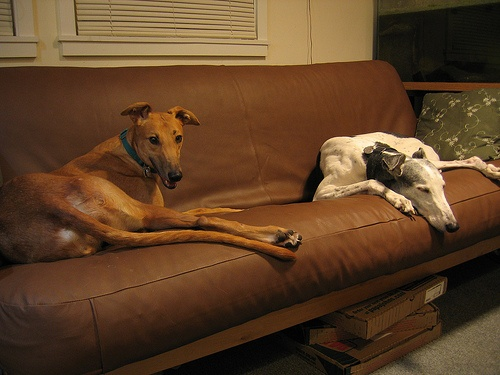

In [8]:
# Loading a few image samples
class Images(enum.Enum):
    img_1 = '000001.jpg'
    img_2 = '000005.jpg'
    img_3 = '000108.jpg'
    
    
image_file = Images.img_3.value
display_image(image_file)

### 1. Running Inference using SageMaker APIs

The sample code below shows how to use sagemaker's runtime API. 

#### 1.1. Instantiate SageMaker runtime

In [9]:
runtime = boto3.Session().client(service_name='sagemaker-runtime')

INFO: 03/07/2022 15:39:49.840124 credentials.py:1233 [cvflowbackend] Found credentials in shared credentials file: ~/.aws/credentials


#### 1.2. Deploy & Get endpoint name

It is required to deploy the model and get the endpoint name of the model <br>
There are 2 options: 

1. Use the deploy python API and get the endpoint name
2. On the SageMaker console, create a Model with endpoint configuration under the Inference section



#### 1.2.1 Using deploy API

In [10]:
# Deploys the model that was generated by fit() to a SageMaker endpoint
deploy = estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')
endpoint_name = deploy.endpoint_name

INFO: 03/07/2022 15:39:50.682997 session.py:2660 [cvflowbackend] Creating model with name: test-notebook-2022-03-07-23-39-50-502
INFO: 03/07/2022 15:39:50.964425 session.py:3541 [cvflowbackend] Creating endpoint-config with name test-notebook-2022-03-07-23-39-50-502
INFO: 03/07/2022 15:39:51.045426 session.py:3034 [cvflowbackend] Creating endpoint with name test-notebook-2022-03-07-23-39-50-502


----------------!

#### 1.2.2 Using SageMaker console

In [11]:
# Create Model under inference section on the SageMaker console
endpoint_name = 'xxx'

#### 1.3. Load the image

In [12]:
img = open(image_file, 'rb').read()

#### 1.4. Call the runtime API and read the response.

In [13]:
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='image/jpg', 
    Body=bytearray(img)
)

# Read the `Body` of the response (in application/json format)
result = response['Body'].read()

# Load the result into a dictionary
res_dict = json.loads(result)

#### 1.5. Get the box, scores and labels and display the image

[0.98780173 0.9006392  0.8925471 ]
3


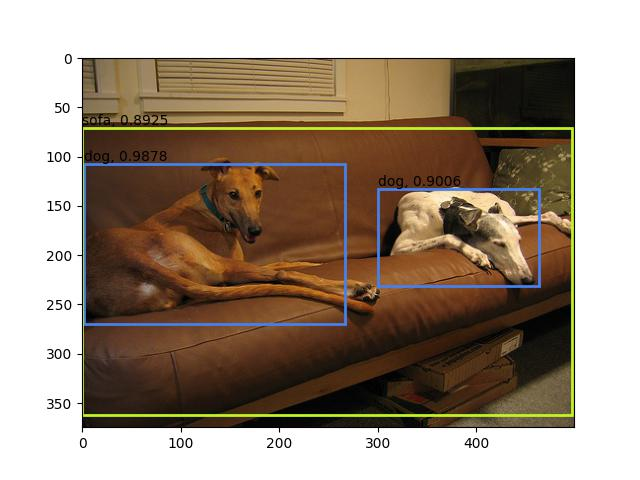

In [14]:
bboxes = np.asarray(res_dict['bboxes'][0], dtype=np.float32)
scores = np.asarray(res_dict['scores'][0], dtype=np.float32)
labels = np.asarray(res_dict['labels'][0], dtype=np.int32)

output_image_file = draw_bbox(image_file, bboxes, scores, labels)
display_image(output_image_file)

### 2. Running Inference using CVFlow APIs

The output of training is CVFlow's AmbaPB fast checkpoint saved in the output S3 path provided by users. <br>
Inference involves the following: 
1. Retrieve the model from S3 output path
2. Load the fast checkpoint
3. Create an Inference Session 
4. Load the image
5. Call sess.run()

In [15]:
from cvflowbackend.evaluation_stage import InferenceSession

#### 2.1. Retrieve the model from S3

In [16]:
BUCKET_NAME = 'bucket_name'
KEY = '<user_path>/output/model.tar.gz'

s3 = boto3.resource('s3')
s3.Bucket(BUCKET_NAME).download_file(KEY, 'model.tar.gz')

INFO: 03/07/2022 15:48:25.876113 credentials.py:1233 [cvflowbackend] Found credentials in shared credentials file: ~/.aws/credentials


In [17]:
output = tarfile.open('model.tar.gz')
output.extractall()
fast_checkpoint = "output/primitive.ambapb.fastckpt.onnx"

#### 2.2 Create an Inference session

In [18]:
# Inference session
sess = InferenceSession(fast_checkpoint, mode="acinf", cuda_devices=0)
i_configs = sess.get_input_configs()

INFO: 03/07/2022 15:48:33.555305 logging.py:314 [Eval Stage] ---------------------------------------------------------------
INFO: 03/07/2022 15:48:33.557535 logging.py:314 [Eval Stage] ---------------- Initializing InferenceSession ----------------
INFO: 03/07/2022 15:48:33.558389 logging.py:314 [Eval Stage] ---------------------------------------------------------------
INFO: 03/07/2022 15:48:36.989643 __init__.py:114 [Eval Stage] Created runtime MetaNode: ONNX(pre_process, engine=native)
INFO: 03/07/2022 15:48:36.990950 __init__.py:115 [Eval Stage]   inputs -> ['input']
INFO: 03/07/2022 15:48:36.991778 __init__.py:116 [Eval Stage]   outputs -> ['107', '135', '138', '233']
INFO: 03/07/2022 15:48:37.006398 orcvpcontext.py:194 [Eval Stage] Writing primitive graph json: /tmp/tmpo1lh4rsp_feature_extractor_pid_83446/feature_extractor.json
INFO: 03/07/2022 15:48:37.028685 orcvpcontext.py:200 [Eval Stage] Writing 244 primitive graph immediates
INFO: 03/07/2022 15:48:37.490058 ambacnn_helper

#### 2.3 Create a feed dict for an input image

In [19]:
feed_dict = {}
model_input_shape_tuple = (i_configs[0].shape[2], i_configs[0].shape[3])
img_array = read_image(image_file, model_input_shape_tuple)
feed_dict[i_configs[0].name] = [img_array]

#### 2.4 Load the image and run forward pass

In [20]:
# Load inputs
sess.set_inputs(feed_dict)

# Run forward pass
res_dict = sess.run()

INFO: 03/07/2022 15:48:37.668532 ambacnnop.py:85 [Eval Stage] VP(feature_extractor, engine=acinference) config: forward_quantized=False, dump_quantized=True
INFO: 03/07/2022 15:48:37.669862 __init__.py:186 [Eval Stage] ********************************************************
INFO: 03/07/2022 15:48:37.670722 __init__.py:187 [Eval Stage] * Running context 1/3 ONNX(pre_process, engine=native) *
INFO: 03/07/2022 15:48:37.671506 __init__.py:188 [Eval Stage] ********************************************************
INFO: 03/07/2022 15:48:37.815236 __init__.py:205 [Eval Stage] Completed 1/1 job(s). Mean latency: 0.143s, throughput: 6.994/s.
INFO: 03/07/2022 15:48:37.816224 __init__.py:186 [Eval Stage] *****************************************************************
INFO: 03/07/2022 15:48:37.816967 __init__.py:187 [Eval Stage] * Running context 2/3 VP(feature_extractor, engine=acinference) *
INFO: 03/07/2022 15:48:37.817685 __init__.py:188 [Eval Stage] *****************************************

opened session 6536 on libambacnn cv2.qa.2022-03-06.1265.cuda9.2 (70bc231*0), at 2022-03-07 15:48:40
libambacnn session config: target_device = cv2, gpu_id = 0, mode = default, split = False


INFO: 03/07/2022 15:48:42.675325 __init__.py:205 [Eval Stage] Completed 1/1 job(s). Mean latency: 4.857s, throughput: 0.206/s.
INFO: 03/07/2022 15:48:42.677029 __init__.py:186 [Eval Stage] *****************************************************
INFO: 03/07/2022 15:48:42.677973 __init__.py:187 [Eval Stage] * Running context 3/3 ONNX(detector, engine=native) *
INFO: 03/07/2022 15:48:42.678709 __init__.py:188 [Eval Stage] *****************************************************
INFO: 03/07/2022 15:48:42.791855 __init__.py:205 [Eval Stage] Completed 1/1 job(s). Mean latency: 0.112s, throughput: 8.896/s.


#### 2.5 Draw bbox and display the image

[0.98780185 0.9006386  0.89254713]
3


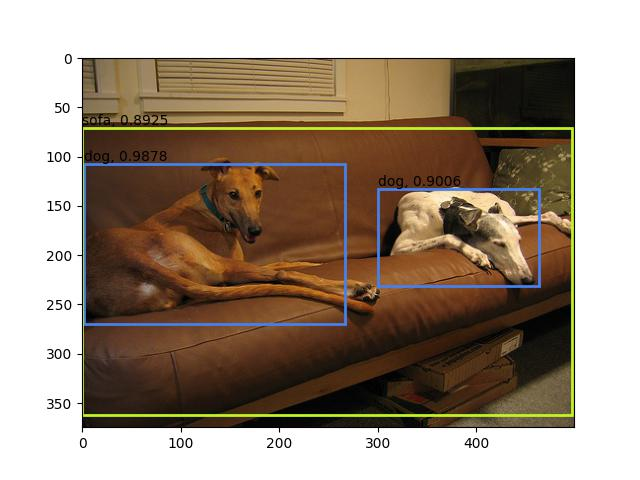

In [21]:
bboxes = np.asarray(res_dict['bboxes'][0], dtype=np.float32)
scores = np.asarray(res_dict['scores'][0], dtype=np.float32)
labels = np.asarray(res_dict['labels'][0], dtype=np.int32)

output_image_file = draw_bbox(image_file, bboxes, scores, labels)
display_image(output_image_file)